In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from time import time
from functools import partial

jax.config.update("jax_debug_nans", True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport solver.hydro
%aimport solver.solvers
%aimport solver.limiters
%aimport solver.muscl

# Blast Wave in 2-D

In [3]:
def imshow(f, size=10, axis=None):
    plt.figure(figsize=(size, size))
    if axis is None:
        extent = None
    else:
        extent = [axis.min(), axis.max(), axis.min(), axis.max()]

    plt.imshow(np.transpose(f), origin="lower", extent=extent)
    plt.colorbar()


def title(e0=1e5, d0=1.0, C=0.5, n=128):
    plt.title("e0={:.0e}   d0={:.0e}   C={:.1f}  n={}".format(e0, d0, C, n))

In [4]:
def blast_func(x, y, n, ds, e0=1e3, d0=0.0, power=2, w=3.0):
    # distance to center
    radius = jnp.sqrt(x[:, None] ** 2 + y[None, :] ** 2)
    profile = jnp.exp(-((radius / (w * ds)) ** power))
    B = 1 / (ds**2 * jnp.sum(profile))
    return np.ones((n, n)) + B * e0 * profile


state = solver.hydro.create_hydro_state(128, 2.0, func=partial(blast_func, w=10))
print(state.total_energy)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Skipped CUDA versions constraints check due to the JAX_SKIP_CUDA_CONSTRAINTS_CHECK env var being set.
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


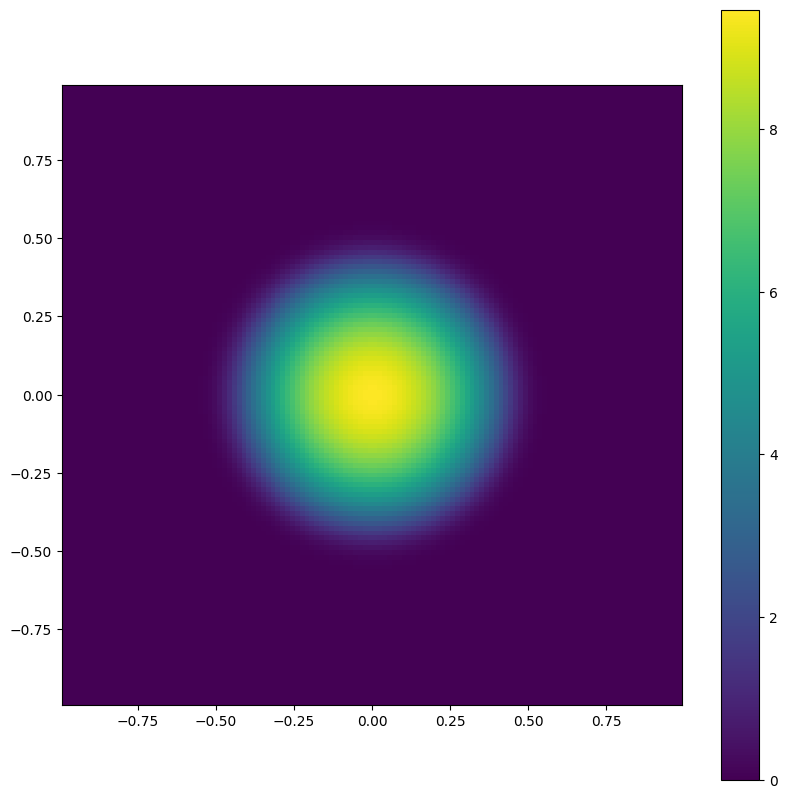

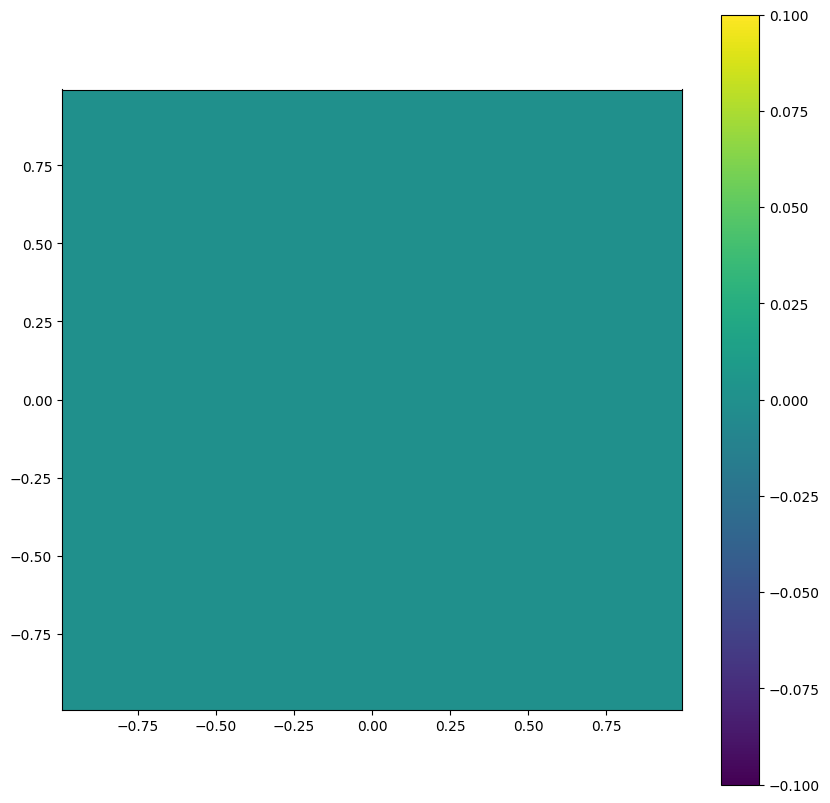

In [5]:
imshow(np.log(state.total_energy), axis=state.x)
imshow(np.log(state.density), axis=state.x)

### A small Blast Wave example

0 2.5741e-05
1 2.5333642e-05
2 2.3817895e-05
3 2.259684e-05
4 2.1788881e-05
5 2.139406e-05
6 2.1401835e-05
7 2.1740936e-05
8 2.2040238e-05
9 2.2387054e-05
10 2.2929791e-05
11 2.3642524e-05
12 2.4431612e-05
13 2.537286e-05
14 2.6318743e-05
15 2.7087524e-05
16 2.795916e-05
17 2.8886794e-05
18 2.9915538e-05
19 3.1014577e-05
20 3.2179552e-05
21 3.3346376e-05
22 3.4126402e-05
23 3.4935652e-05
24 3.5729205e-05
25 3.646629e-05
26 3.7142574e-05
27 3.7688606e-05
28 3.812133e-05
29 3.8418577e-05
30 3.861361e-05
31 3.8723552e-05
32 3.8779417e-05
33 3.878655e-05
34 3.880156e-05
35 3.8821472e-05
36 3.8877355e-05
37 3.8980263e-05
38 3.913072e-05
39 3.932556e-05
40 3.9554336e-05
41 3.975967e-05
42 3.9992625e-05
43 4.0252384e-05
44 4.0521332e-05
45 4.0800387e-05
46 4.1079424e-05
47 4.1356285e-05
48 4.1626263e-05
49 4.1887488e-05
50 4.213602e-05
51 4.2372452e-05
52 4.259652e-05
53 4.2809246e-05
54 4.3010125e-05
55 4.3200926e-05
56 4.33824e-05
57 4.355732e-05
58 4.372616e-05
59 4.389088e-05
60 4.405218e

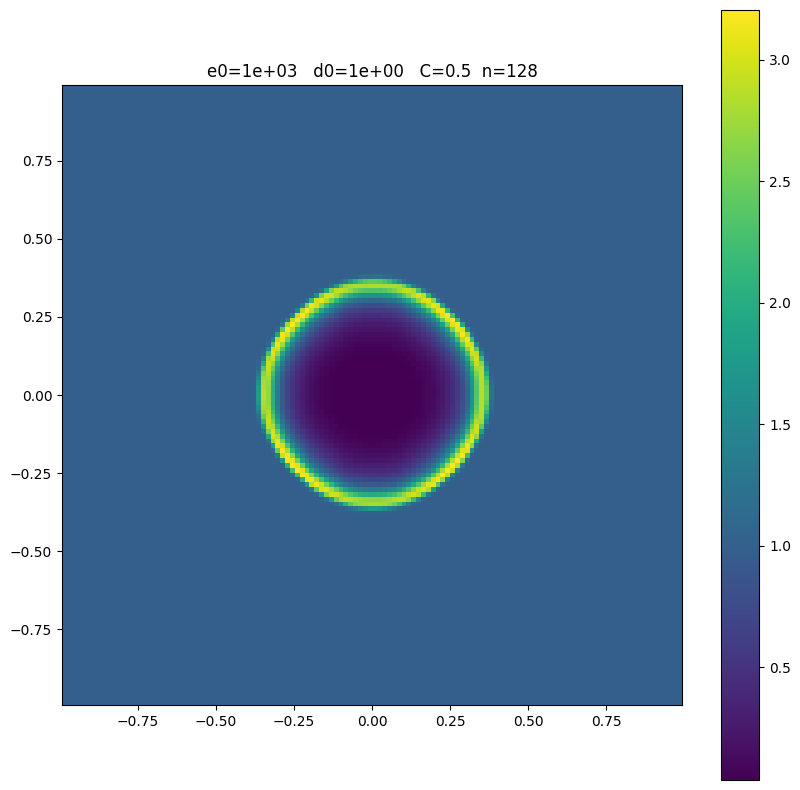

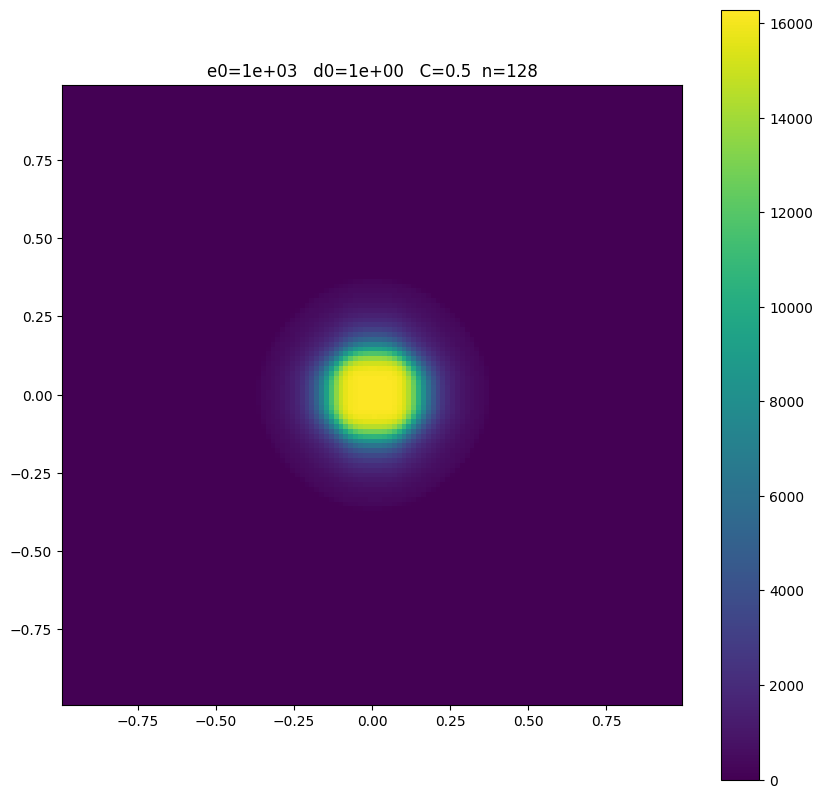

In [44]:
e0 = 1e3
n = 128
C = 0.5
nt = 100
riemann_solver = solver.solvers.local_lax_friedrichs
slope_limiter = solver.limiters.monotonized_central
state = solver.hydro.create_hydro_state(n, 2.0, func=partial(blast_func, e0=e0, power=4, w=3.0))
start = time()

for it in range(nt):
    dt = solver.hydro.courant_condition(state, C)
    print(it, dt)
    state = solver.muscl.muscl_2d(
        state, dt, slope_limiter=slope_limiter, riemann_solver=riemann_solver
    )
used = time() - start

print("{:.1f} sec, {:.2f} microseconds/update".format(used, 1e6 * used / (n**2 * nt)))
imshow(state.density, axis=state.x)
title(e0=e0, C=C, n=n)
imshow(solver.hydro.temperature(state), axis=state.x)
title(e0=e0, C=C, n=n)